In [282]:
#importing necessary libraries
import pandas as pd
import glob
import os
import warnings
import time
import numpy as np
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
# importing custom scripts for different functions
sys.path.append('scripts')  # add scripts to path




# Ignore warnings
warnings.filterwarnings("ignore")

In [283]:
data = pd.read_csv("combined.csv")
data.head()

,Commodity,Classification,Grade,Sex,Market,Wholesale,Retail,Supply Volume,County,Date
0,Banana (Ripening),-,-,-,Mukuyu Market,-,50.00/Kg,NaN,Muranga,2026-02-11
1,Banana (Ripening),-,-,-,Mulot,70.00/Kg,100.00/Kg,1500.0,Bomet,2026-02-11
2,Banana (Ripening),-,-,-,Kitale Municipality Market,80.00/Kg,100.00/Kg,6000.0,Trans-Nzoia,2026-02-11
3,Banana (Ripening),-,-,-,Kerugoya,20.00/Kg,40.00/Kg,300.0,Kirinyaga,2026-02-10
4,Banana (Ripening),-,-,-,Bondeni,80.00/Kg,100.00/Kg,5000.0,Trans-Nzoia,2026-02-10


In [284]:
data.isnull().sum()

Commodity             0
Classification        0
Grade                 0
Sex                   0
Market                0
Wholesale             0
Retail                0
Supply Volume     17775
County               19
Date                  0
dtype: int64

In [285]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57010 entries, 0 to 57009
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Commodity       57010 non-null  object 
 1   Classification  57010 non-null  object 
 2   Grade           57010 non-null  object 
 3   Sex             57010 non-null  object 
 4   Market          57010 non-null  object 
 5   Wholesale       57010 non-null  object 
 6   Retail          57010 non-null  object 
 7   Supply Volume   39235 non-null  float64
 8   County          56991 non-null  object 
 9   Date            57010 non-null  object 
dtypes: float64(1), object(9)
memory usage: 4.3+ MB


In [286]:
data.duplicated().sum()

4259

In [287]:
data.drop_duplicates(inplace=True)
data.reset_index(drop=True, inplace=True)

In [288]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52751 entries, 0 to 52750
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Commodity       52751 non-null  object 
 1   Classification  52751 non-null  object 
 2   Grade           52751 non-null  object 
 3   Sex             52751 non-null  object 
 4   Market          52751 non-null  object 
 5   Wholesale       52751 non-null  object 
 6   Retail          52751 non-null  object 
 7   Supply Volume   36539 non-null  float64
 8   County          52743 non-null  object 
 9   Date            52751 non-null  object 
dtypes: float64(1), object(9)
memory usage: 4.0+ MB


In [289]:
data['County'] = data.groupby('Market')['County'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else "Unknown"))

In [290]:
# Filling NaNs using the median volume for each specific commodity
data['Supply Volume'] = data.groupby(['Commodity', 'Market'])['Supply Volume'].transform(lambda x: x.fillna(x.median()))
#data['Supply Volume'] = data['Supply Volume'].fillna(0)

In [291]:
data.isnull().sum()

Commodity            0
Classification       0
Grade                0
Sex                  0
Market               0
Wholesale            0
Retail               0
Supply Volume     9251
County               0
Date                 0
dtype: int64

In [292]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52751 entries, 0 to 52750
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Commodity       52751 non-null  object 
 1   Classification  52751 non-null  object 
 2   Grade           52751 non-null  object 
 3   Sex             52751 non-null  object 
 4   Market          52751 non-null  object 
 5   Wholesale       52751 non-null  object 
 6   Retail          52751 non-null  object 
 7   Supply Volume   43500 non-null  float64
 8   County          52751 non-null  object 
 9   Date            52751 non-null  object 
dtypes: float64(1), object(9)
memory usage: 4.0+ MB


In [293]:
data['Supply Volume'] = data.groupby('Commodity')['Supply Volume'].transform(lambda x: x.fillna(x.median()))

In [294]:
data= data.drop(columns=["Classification", "Grade", "Sex"])

In [295]:
data.head()

,Commodity,Market,Wholesale,Retail,Supply Volume,County,Date
0,Banana (Ripening),Mukuyu Market,-,50.00/Kg,1500.0,Muranga,2026-02-11
1,Banana (Ripening),Mulot,70.00/Kg,100.00/Kg,1500.0,Bomet,2026-02-11
2,Banana (Ripening),Kitale Municipality Market,80.00/Kg,100.00/Kg,6000.0,Trans-Nzoia,2026-02-11
3,Banana (Ripening),Kerugoya,20.00/Kg,40.00/Kg,300.0,Kirinyaga,2026-02-10
4,Banana (Ripening),Bondeni,80.00/Kg,100.00/Kg,5000.0,Trans-Nzoia,2026-02-10


In [296]:
data.isnull().sum()

Commodity        0
Market           0
Wholesale        0
Retail           0
Supply Volume    0
County           0
Date             0
dtype: int64

In [297]:
def clean_price(series):
	clean_series = pd.to_numeric(series.astype(str).str.replace('[^0-9.]', '', regex=True), errors='coerce')
	return clean_series

data["Wholesale"] = clean_price(data["Wholesale"])
data["Retail"] = clean_price(data["Retail"])

In [298]:
data.isnull().sum()

Commodity            0
Market               0
Wholesale        11061
Retail            2194
Supply Volume        0
County               0
Date                 0
dtype: int64

In [299]:
data["Wholesale"] = data["Wholesale"].fillna(0)
data["Retail"] = data["Retail"].fillna(0)

In [300]:
data.isnull().sum()

Commodity        0
Market           0
Wholesale        0
Retail           0
Supply Volume    0
County           0
Date             0
dtype: int64

In [301]:
# Calculate absolute price difference
data['Price_Margin'] = data['Retail'] - data['Wholesale']
data = data[data['Wholesale'] > 0].copy()
# Calculate percentage margin, handling division by zero
data['Margin_Percentage'] = (data['Price_Margin'] / data['Wholesale']) * 100

In [302]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41690 entries, 1 to 52750
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Commodity          41690 non-null  object 
 1   Market             41690 non-null  object 
 2   Wholesale          41690 non-null  float64
 3   Retail             41690 non-null  float64
 4   Supply Volume      41690 non-null  float64
 5   County             41690 non-null  object 
 6   Date               41690 non-null  object 
 7   Price_Margin       41690 non-null  float64
 8   Margin_Percentage  41690 non-null  float64
dtypes: float64(5), object(4)
memory usage: 3.2+ MB


#### Which are Top 10 Commodities by Average Margin Percentage?

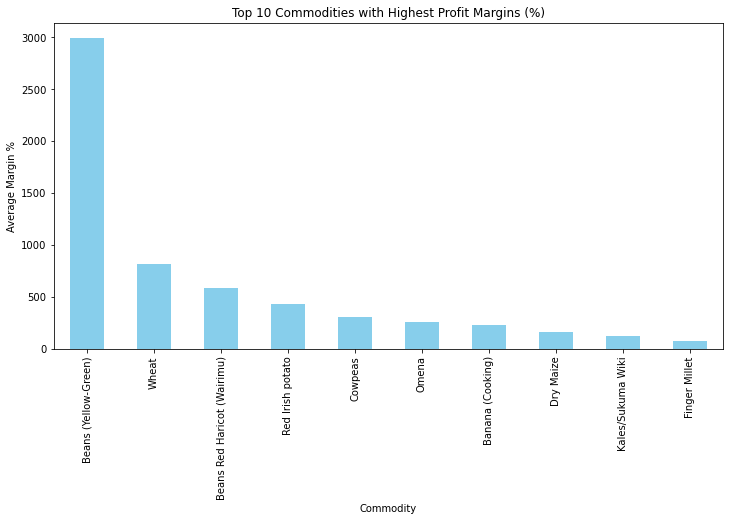

In [303]:
plt.figure(figsize=(12, 6))
data.groupby('Commodity')['Margin_Percentage'].mean().sort_values(ascending=False).head(10).plot(kind='bar', color='skyblue')
plt.title('Top 10 Commodities with Highest Profit Margins (%)')
plt.ylabel('Average Margin %')
plt.show()

**Yellow-Green beans makes the highest profit margin**

#### Which are Top 10 Counties by Total Supply Volume?

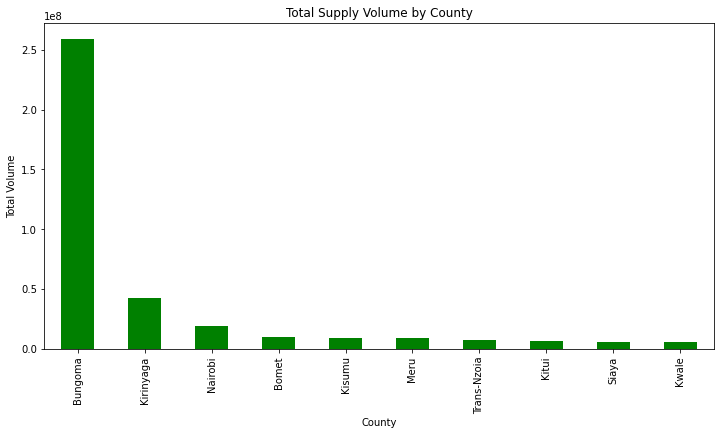

In [304]:
plt.figure(figsize=(12, 6))
data.groupby('County')['Supply Volume'].sum().sort_values(ascending=False).head(10).plot(kind='bar', color='green')
plt.title('Total Supply Volume by County')
plt.ylabel('Total Volume')
plt.show()

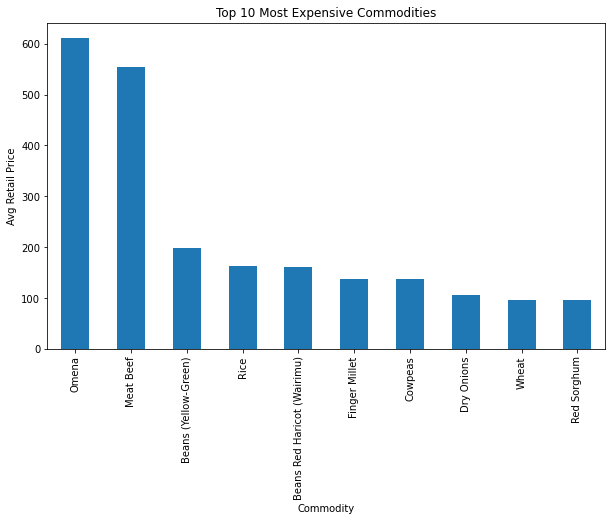

In [305]:
plt.figure(figsize=(10,6))
data.groupby('Commodity')['Retail'].mean().sort_values(ascending=False).head(10).plot(kind='bar')
plt.ylabel("Avg Retail Price")
plt.title("Top 10 Most Expensive Commodities")
plt.show()

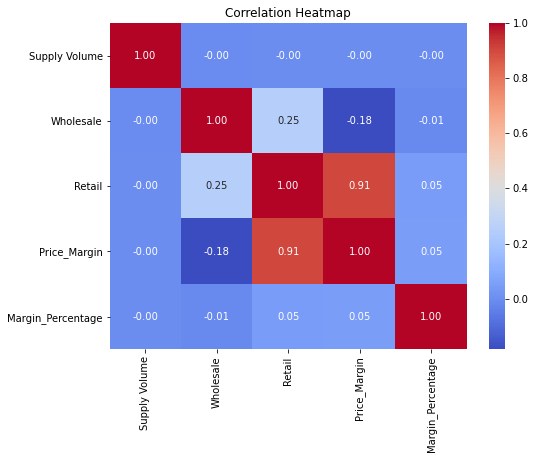

In [306]:
plt.figure(figsize=(8, 6))
correlation = data[['Supply Volume', 'Wholesale', 'Retail', 'Price_Margin', 'Margin_Percentage']].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

**Supply volume have no correlation with the prices both wholesale and retail where as The price margin has a strong positive correlation of 91% with Retail prices.**

In [307]:
# Sorting data by Date and Commodity
data = data.sort_values(['Commodity', 'Date'])

# Using linear interpolation to fill gaps in price trends
data['Retail'] = data.groupby('Commodity')['Retail'].transform(lambda x: x.interpolate(method='linear'))
data['Wholesale'] = data.groupby('Commodity')['Wholesale'].transform(lambda x: x.interpolate(method='linear'))

In [308]:
# Calculate Coefficient of Variation - a measure of volatility
volatility = data.groupby('Commodity')['Retail'].std() / data.groupby('Commodity')['Retail'].mean()
print("Top 5 Most Volatile Commodities (Hardest to predict):")
print(volatility.sort_values(ascending=False).head())

Top 5 Most Volatile Commodities (Hardest to predict):
Commodity
Banana (Cooking)               3.915273
Dry Maize                      3.300950
Beans Red Haricot (Wairimu)    3.284186
Beans (Yellow-Green)           3.184903
Finger Millet                  2.875688
Name: Retail, dtype: float64


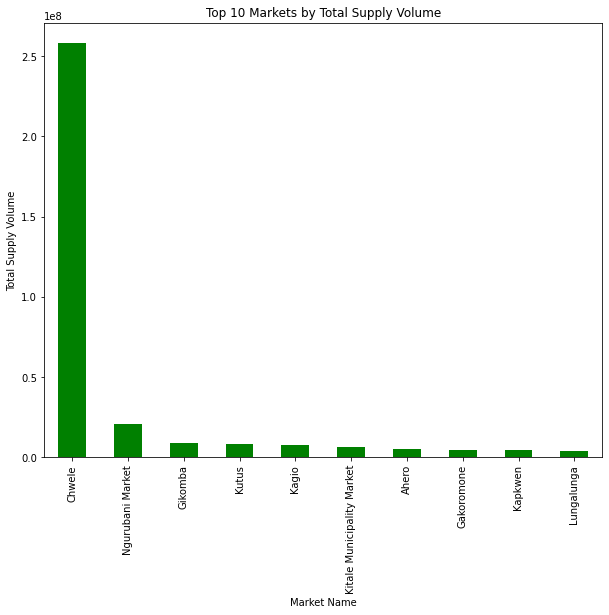

In [309]:
plt.figure(figsize=(10,8))
data.groupby('Market')['Supply Volume'].sum().sort_values(ascending=False).head(10).plot(kind='bar', color='green')
plt.xlabel("Market Name")
plt.ylabel("Total Supply Volume")
plt.title('Top 10 Markets by Total Supply Volume')
plt.show()

In [310]:
# Creating a list of markets for major cities
Nairobi_data = data[data['County'].str.contains('Nairobi', case=False, na=False)]


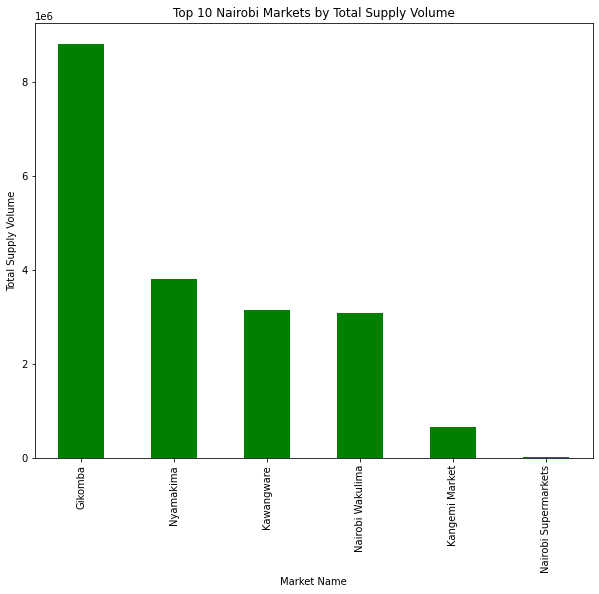

In [311]:
plt.figure(figsize=(10,8))
Nairobi_data.groupby('Market')['Supply Volume'].sum().sort_values(ascending=False).head(10).plot(kind='bar', color='green')
plt.xlabel("Market Name")
plt.ylabel("Total Supply Volume")
plt.title('Top 10 Nairobi Markets by Total Supply Volume')
plt.show()

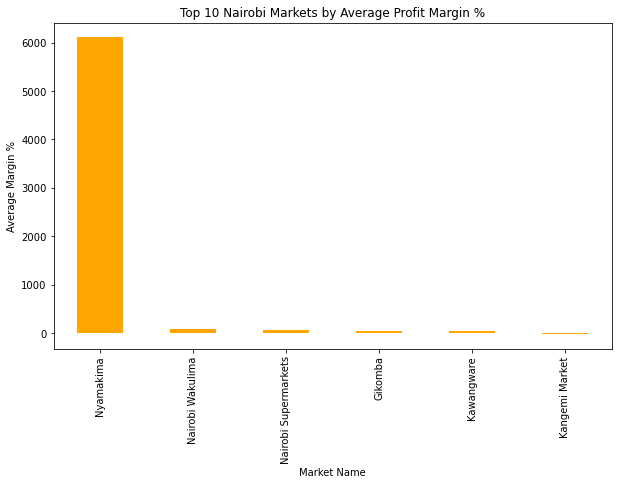

In [312]:
plt.figure(figsize=(10,6))
Nairobi_data.groupby('Market')['Margin_Percentage'].mean().sort_values(ascending=False).head(10).plot(kind='bar', color='orange')
plt.xlabel("Market Name")
plt.ylabel("Average Margin %")
plt.title('Top 10 Nairobi Markets by Average Profit Margin %')
plt.show()

Modelling

In [313]:
# Converting to datetime and sort
data['Date'] = pd.to_datetime(data['Date'])
df_target = data[data['Commodity'] == 'Rice'].sort_values('Date')
df_target.set_index('Date', inplace=True)
ts = df_target['Retail'].resample('D').mean().ffill()

Feature Engineering

In [314]:
def create_features(df):
    df= df.to_frame()
    df['lag_1'] = df['Retail'].shift(1) # Yesterday's price
    df['lag_7'] = df['Retail'].shift(7) # Price a week ago
    df['dayofweek'] = df.index.dayofweek
    return df.dropna()
features= create_features(ts)

In [315]:
X = features.drop(columns=['Retail'])
y = features['Retail']

In [316]:
split_index = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]
print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")

Train size: 526, Test size: 132


In [317]:
model_sarima = SARIMAX(y_train, order=(1,1,1), seasonal_order=(1,1,1,12))
results_sarima = model_sarima.fit(disp=False)
forecast_sarima= results_sarima.forecast(steps=len(y_test))
#mean_forecast =  forecast_sarima.predicted_mean

In [318]:
rmse_sarima = np.sqrt(mean_squared_error(y_test, forecast_sarima))
print(f"SARIMA RMSE: {rmse_sarima:.2f}")

SARIMA RMSE: 18.06


XGBOOST MODELLING

In [319]:
xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5)

In [320]:
xgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [321]:
predictions = xgb_model.predict(X_test)
xgb_rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"XGBOOST RMSE:	{xgb_rmse:.2f}")

XGBOOST RMSE:	16.65


LSTM

In [322]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(features)
scaled_df = pd.DataFrame(scaled_data, columns=features.columns, index=features.index)
print("Scaled data shape:", scaled_df.shape)
scaled_df.head()

Scaled data shape: (658, 4)


,Retail,lag_1,lag_7,dayofweek
Date,,,,
2024-04-25,0.311402,0.288040,0.221862,0.500000
2024-04-26,0.241210,0.311402,0.244856,0.666667
2024-04-27,0.321272,0.241210,0.308265,0.833333
2024-04-28,0.244856,0.321272,0.308265,1.000000
2024-04-29,0.252888,0.244856,0.264367,0.000000


In [323]:
X_scaled = scaled_df.drop(columns=['Retail']).values
y_scaled = scaled_df['Retail'].values

In [324]:
split_index = int(len(X_scaled) * 0.8)
X_train_lstm = X_scaled[:split_index].reshape(-1, 1, X_scaled.shape[1])
X_test_lstm = X_scaled[split_index:].reshape(-1, 1, X_scaled.shape[1])
y_train_lstm = y_scaled[:split_index]
y_test_lstm = y_scaled[split_index:]


In [325]:
model_lstm = Sequential([LSTM(64, activation='relu', input_shape=(1, X_train_lstm.shape[2])), Dense(32, activation= 'relu'), Dense(1)])

In [326]:
model_lstm.compile(optimizer='adam', loss='mse')
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [327]:
history = model_lstm.fit(X_train_lstm, y_train_lstm, epochs=100, batch_size=16, validation_data=(X_test_lstm, y_test_lstm), callbacks=[early_stop], verbose=0)

In [328]:
lstm_preds_scaled = model_lstm.predict(X_test_lstm).flatten()
dummy = np.zeros((len(lstm_preds_scaled), features.shape[1]))
dummy[:, 0] = lstm_preds_scaled
lstm_pred = scaler.inverse_transform(dummy)[:, 0]

In [333]:
rmse_lstm = np.sqrt(mean_squared_error(y_test.values, lstm_pred))
print(f"LSTM RMSE: {rmse_lstm:.2f}")

LSTM RMSE: 12.09


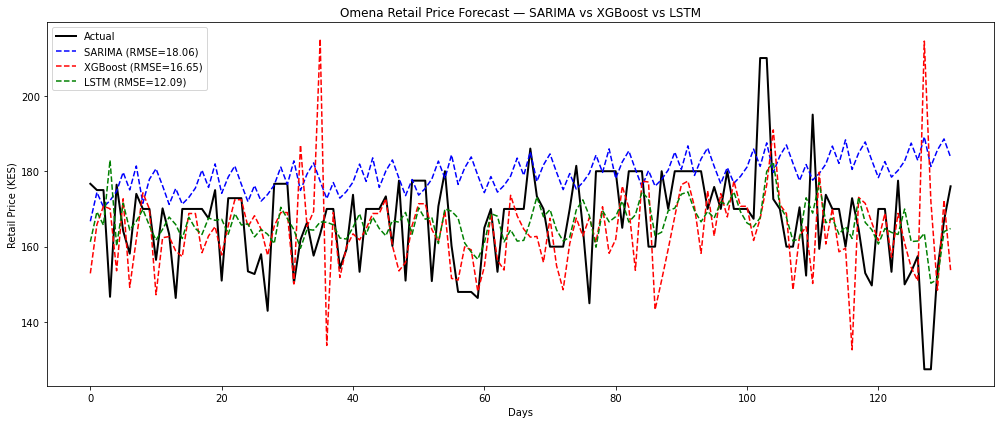

In [ ]:
plt.figure(figsize=(14, 6))
plt.plot(y_test.values, label='Actual', color='black', linewidth=2)
plt.plot(forecast_sarima.values, label=f'SARIMA (RMSE={rmse_sarima:.2f})', color='blue', linestyle='--')
plt.plot(predictions, label=f'XGBoost (RMSE={xgb_rmse:.2f})', color='red', linestyle='--')
plt.plot(lstm_pred, label=f'LSTM (RMSE={rmse_lstm:.2f})', color='green', linestyle='--')
plt.title('Rice Retail Price Forecast — SARIMA vs XGBoost vs LSTM')
plt.xlabel('Days')
plt.ylabel('Retail Price (KES)')
plt.legend()
plt.tight_layout()
plt.show()

In [335]:
print(f"Mean Rice Retail Price: {data[data['Commodity']=='Rice']['Retail'].mean():.2f}")
print(f"LSTM RMSE as % of mean: {12.09 / data[data['Commodity']=='Rice']['Retail'].mean() * 100:.1f}%")

Mean Rice Retail Price: 162.24
LSTM RMSE as % of mean: 7.5%
